In [105]:
import time
import itertools
import math
import decimal
import pandas as pd
from pandas import DataFrame
from decimal import Decimal as dec
import seaborn as sns
import numpy as np
from numpy import random as np_rnd
import scipy
from scipy.stats.distributions import norm
import random as rnd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.ticker import MultipleLocator
from IPython.display import Latex
import networkx as nx 

%matplotlib notebook

# I. Path on weighted graph
#### Constants and matrix generation

In [2]:
VERTICES_COUNT = 100
EDGES_COUNT = 500
POSSIBLE_WEIGHTS = 100

def initialize_adjacency_matrix():
    matrix = np.zeros((VERTICES_COUNT, VERTICES_COUNT), dtype=int)
    possible_positions = []
    for i in range(VERTICES_COUNT):
        for j in range(i + 1, VERTICES_COUNT):
            possible_positions.append({"i": i, "j": j})
    
    occupied_vertices = {}
    for _ in range(EDGES_COUNT):
        is_success = False
        
        while not is_success:
            i_choice = np_rnd.randint(VERTICES_COUNT)
            if i_choice in occupied_vertices: 
                if len(occupied_vertices[i_choice]) == VERTICES_COUNT:
                    continue
            else:
                occupied_vertices[i_choice] = []
            is_success = True
            j_choice = np_rnd.choice([x 
                                      for x 
                                      in range(VERTICES_COUNT) \
                                      if x != i_choice \
                                          and x not in occupied_vertices[i_choice]])
            
            occupied_vertices[i_choice].append(j_choice)
            if j_choice not in occupied_vertices:
                occupied_vertices[j_choice] = []
            occupied_vertices[j_choice].append(i_choice)
            
            weight = np_rnd.randint(1, POSSIBLE_WEIGHTS + 1)
            
            matrix[i_choice][j_choice] = weight
            matrix[j_choice][i_choice] = weight
            
        is_success = False
    
    return matrix

### Dijkstra's algorithm

In [52]:
def dijkstra_shortest_path(matrix, start):
    spt_set = np.repeat(-1, VERTICES_COUNT)
    input_nodes = np.repeat(-1, VERTICES_COUNT)
    input_nodes[start] = -2
    news = {start: 0}
    
    while -1 in spt_set:
        u = min(news, key=news.get)
        spt_set[u] = news[u]
        news.pop(u)
        
        conn = ({i: wgt + spt_set[u] \
                      for i, wgt \
                      in enumerate(matrix[u]) \
                      if wgt != 0 \
                          and spt_set[i] == -1 \
                          and (i not in news or news[i] > spt_set[u] + wgt)})
        
        news.update(conn)
        input_nodes[list(conn.keys())] = u
    
    return spt_set, input_nodes        

Test

<IPython.core.display.Javascript object>


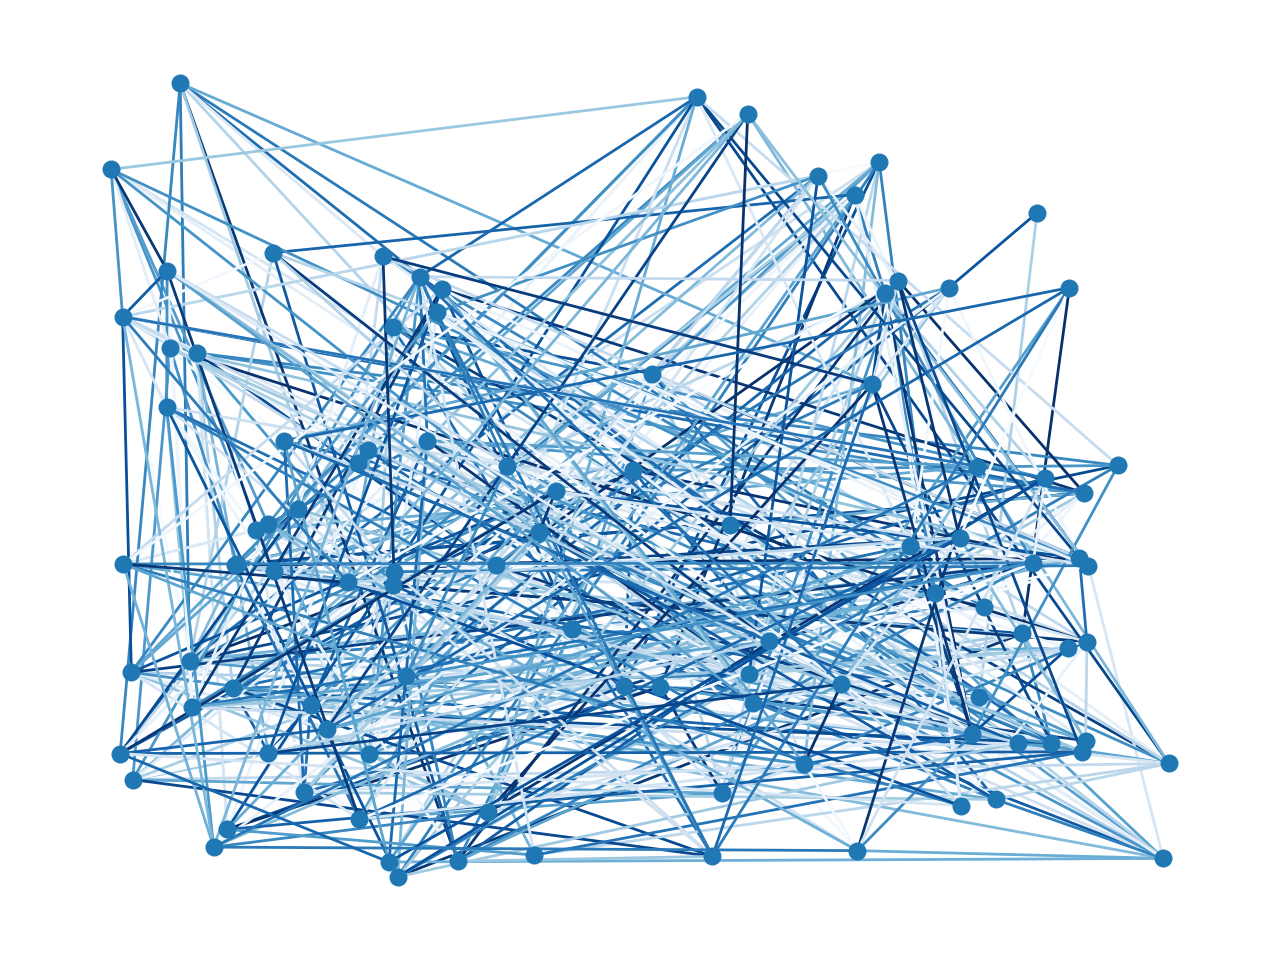

In [23]:
mx = initialize_adjacency_matrix()

G = nx.Graph()
G.add_nodes_from(range(VERTICES_COUNT))
for i in range(VERTICES_COUNT): 
    for j in range(VERTICES_COUNT): 
        if mx[i][j] != 0: 
            G.add_edge(i, j, weight=mx[i][j])

positions = nx.random_layout(G, seed=65536)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw(G, node_size=30, pos = positions, edge_color=weights, edge_cmap=plt.cm.Blues) 
plt.show()

In [53]:
dists, inputs = dijkstra_shortest_path(mx, 10)

<IPython.core.display.Javascript object>


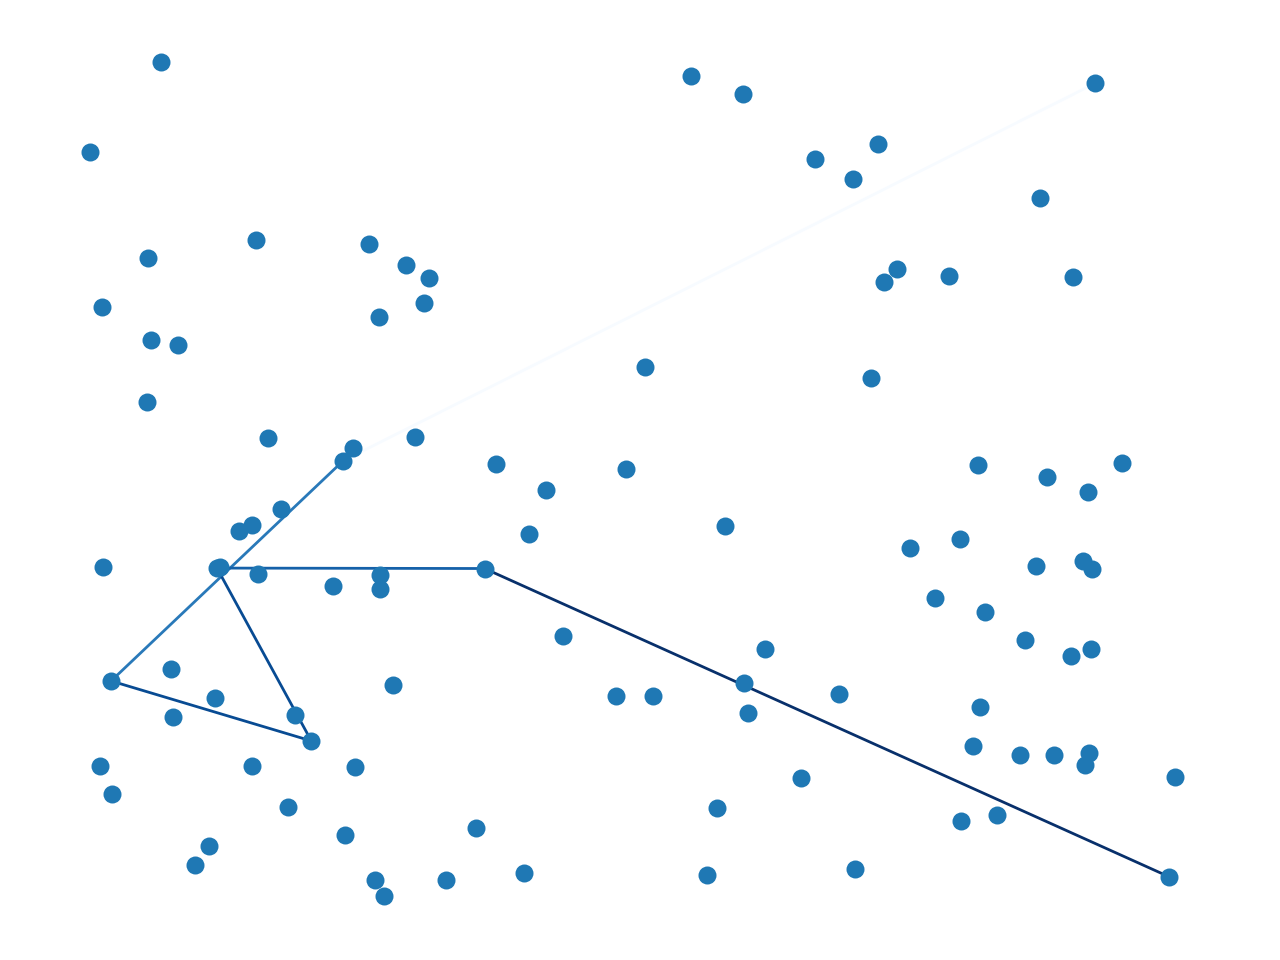

In [65]:
to_point = 15

G = nx.Graph()
G.add_nodes_from(range(VERTICES_COUNT))
prev_pt=to_point
while prev_pt >= 0:
    G.add_edge(prev_pt, inputs[prev_pt], weight=dists[prev_pt]-dists[inputs[prev_pt]])
    prev_pt = inputs[prev_pt]

positions = nx.random_layout(G, seed=65536)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw(G, node_size=30, pos = positions, edge_color=weights, edge_cmap=plt.cm.Blues)#, edge_labels=weights) 
plt.show()

### Bellman-Ford algorithm

In [62]:
def bellman_ford_shortest_path(matrix, start):
    inputs = np.repeat(-1, VERTICES_COUNT)
    dists = np.repeat(-1, VERTICES_COUNT)
    dists[start] = 0
    
    for _ in range(VERTICES_COUNT):
        for i, d in enumerate(dists):
            if d == -1:
                continue
            
            conns = {j: wgt + d \
                     for j, wgt \
                     in enumerate(matrix[i]) \
                     if wgt > 0 \
                         and (dists[j] == -1 or dists[j] > wgt + d)}
            
            dists[list(conns.keys())] = list(conns.values())
            inputs[list(conns.keys())] = i
    
    return dists, inputs

Test

In [67]:
dists, inputs = bellman_ford_shortest_path(mx, 10)

<IPython.core.display.Javascript object>


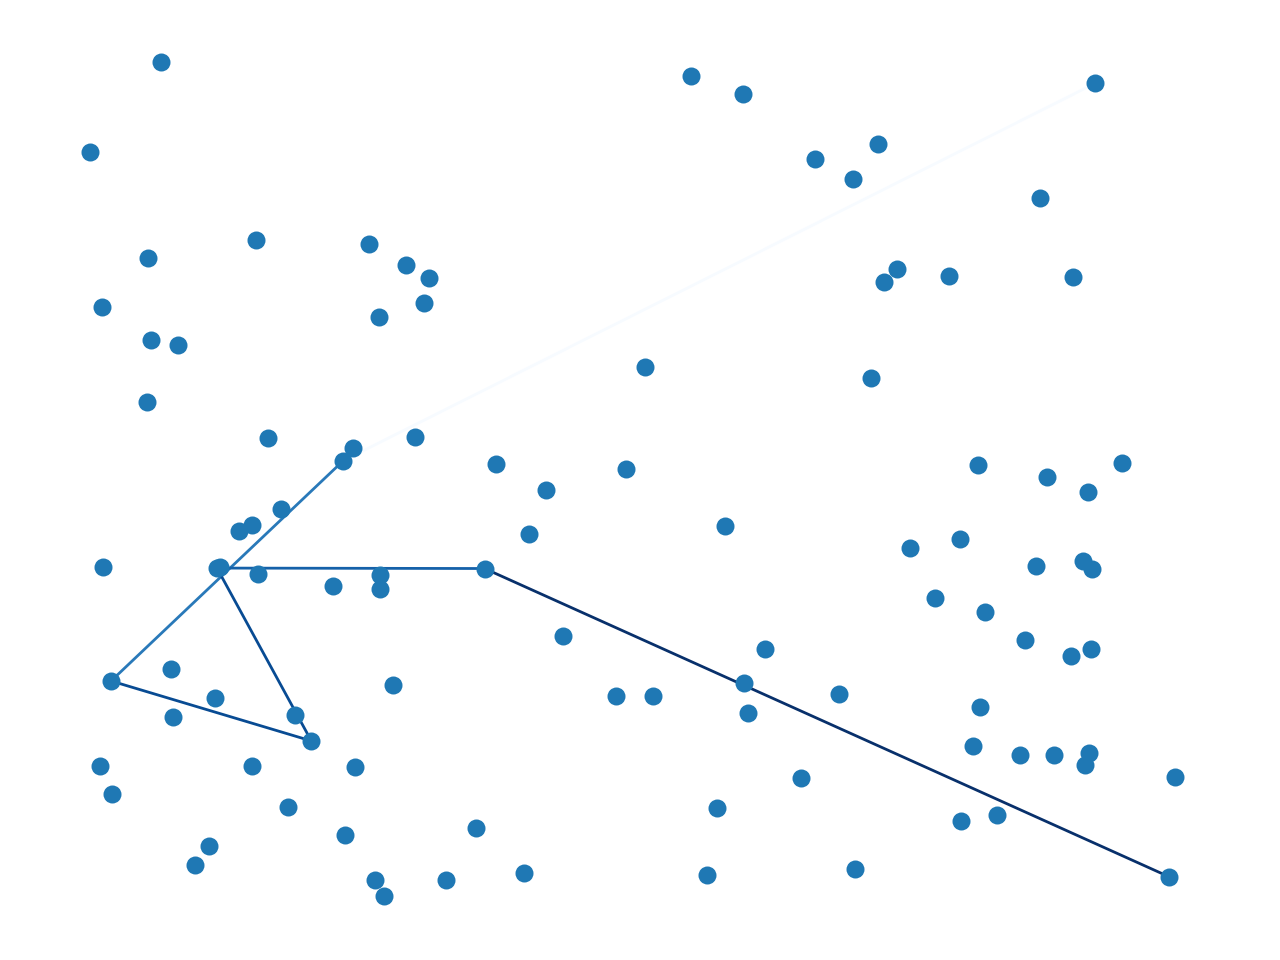

In [68]:
G = nx.Graph()
G.add_nodes_from(range(VERTICES_COUNT))
prev_pt=to_point
while prev_pt >= 0:
    G.add_edge(prev_pt, inputs[prev_pt], weight=dists[prev_pt]-dists[inputs[prev_pt]])
    prev_pt = inputs[prev_pt]

positions = nx.random_layout(G, seed=65536)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw(G, node_size=30, pos = positions, edge_color=weights, edge_cmap=plt.cm.Blues)#, edge_labels=weights) 
plt.show()

#### Conclusion:
algorithms work the same way

### Comparison of algorithms

In [69]:
def measure_runtime(fun, *args):
    time1 = time.time()
    fun(*args)
    return time.time() - time1

In [75]:
results = DataFrame.from_records([[measure_runtime(dijkstra_shortest_path, mx, 10), measure_runtime(bellman_ford_shortest_path, mx, 10)] for _ in range(10)], columns=["Dijkstra", "Bellman-Ford"])
print(f"Dijkstra avg: {results['Dijkstra'].mean()}",\
      f"Bellman-Ford: {results['Bellman-Ford'].mean()}", sep='\n')
results

Dijkstra avg: 0.002962017059326172
Bellman-Ford: 0.23338706493377687


,Dijkstra,Bellman-Ford
0,0.004400,0.270812
1,0.002644,0.218504
2,0.002545,0.221380
3,0.002718,0.237028
4,0.003876,0.238597
5,0.002696,0.253805
6,0.002813,0.227099
7,0.002688,0.218588
8,0.002546,0.231926
9,0.002693,0.216131


# II. Grid with obstackles shortest path
#### Constants and maze generation

In [86]:
MAZE_SIZE = (10,20)
OBSTACKLES = 40

def generate_maze():
    matrix = np.ones(MAZE_SIZE, dtype=int)
    
    for _ in range(OBSTACKLES):
        is_success = False
        while not is_success:
            i_choice = np_rnd.randint(MAZE_SIZE[0])
            j_choice = np_rnd.randint(MAZE_SIZE[1])

            if matrix[i_choice][j_choice] != 1:
                continue
            is_success = True
            
            matrix[i_choice][j_choice] = 0
    
    return matrix

<IPython.core.display.Javascript object>


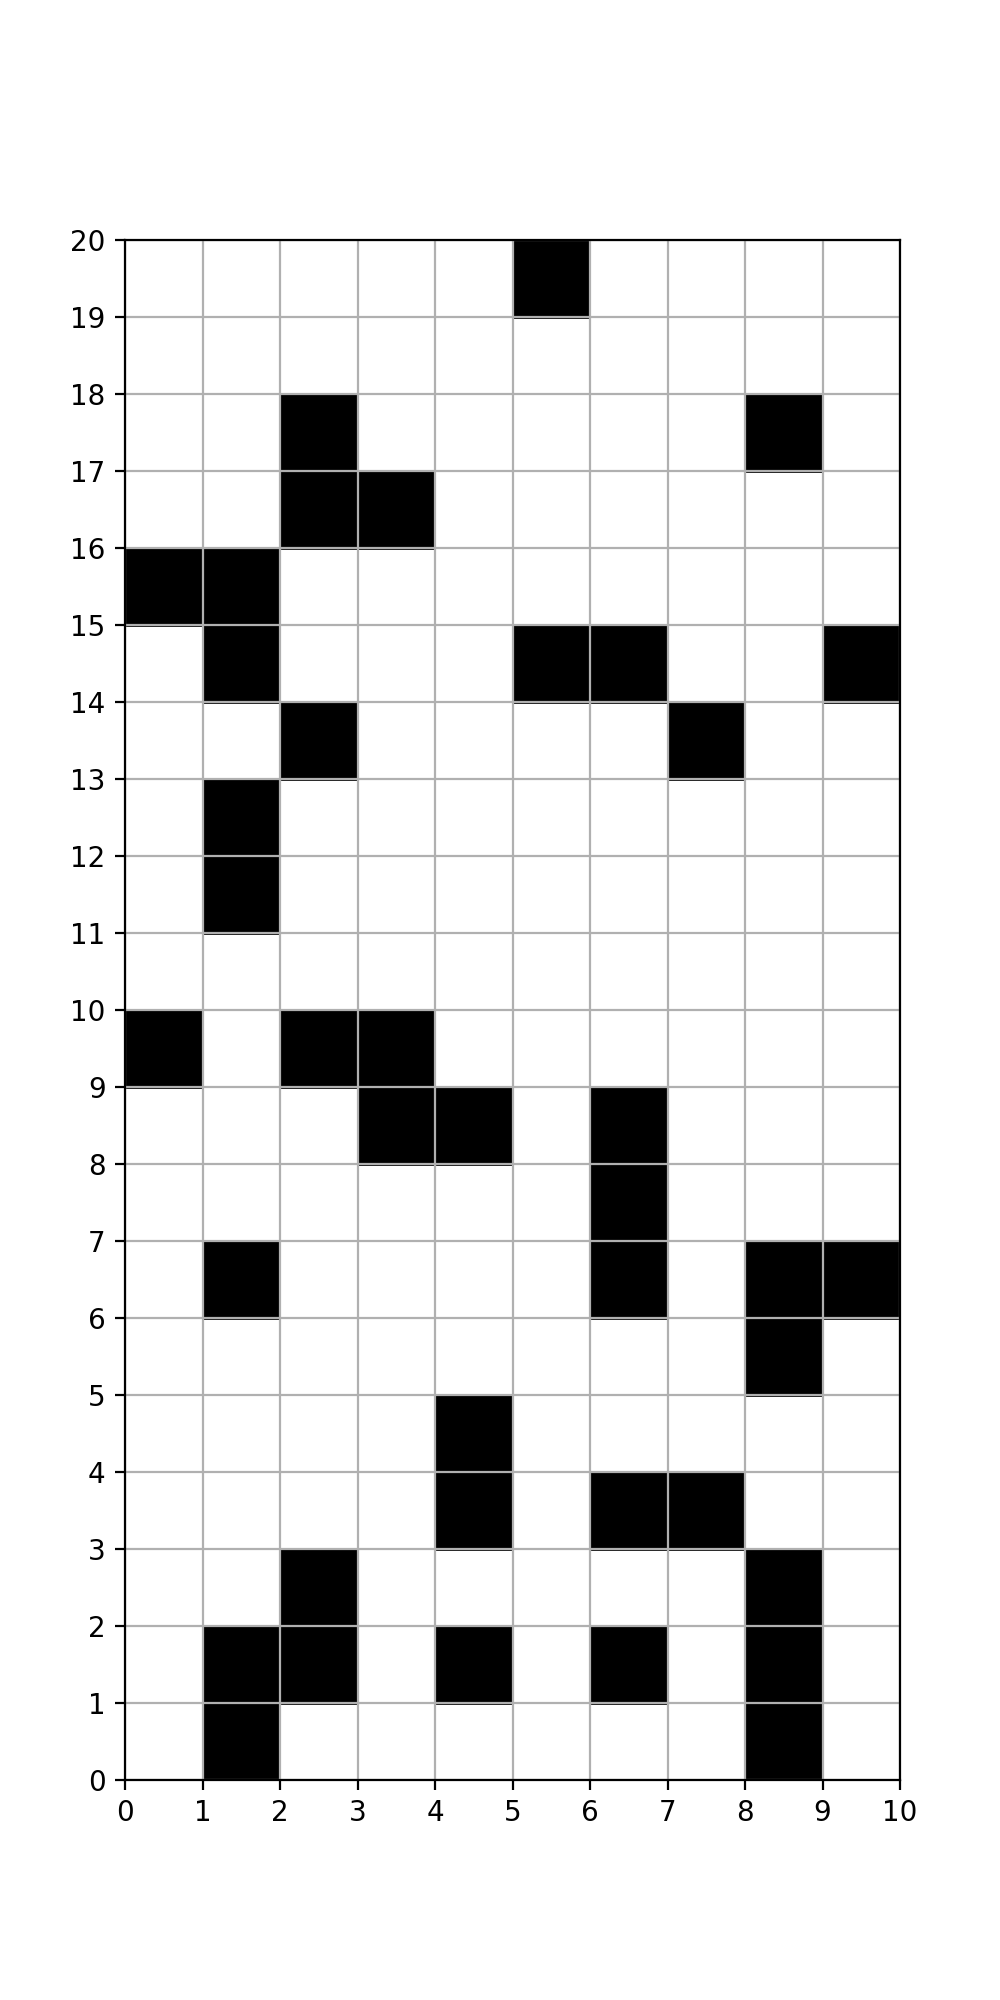

In [121]:
maze = generate_maze()

fig, ax = plt.subplots(figsize=(5, 10))
plt.xlim([0, MAZE_SIZE[0]])
plt.ylim([0, MAZE_SIZE[1]])
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
obst = list(itertools.chain.from_iterable([[[i, j] for j, el in enumerate(col) if el == 0] for i, col in enumerate(maze)]))
plt.scatter([o[0]+.5 for o in obst], [o[1]+.5 for o in obst], marker='s', color='black', linestyle = 'None', s=750)


plt.grid()
plt.show()

### A* algorithm

In [156]:
def a_star_path(matrix, start, end):
    path = {start: 0}
    inputs = {start: None}
    costs = {start: 0}
    
    dist_to_end = lambda pt: math.sqrt((pt[0]-end[0]) * (pt[0]-end[0]) + abs(pt[1]-end[1]) * abs(pt[1]-end[1]))
    def get_neighbours(pt):
        nbs = []
        for i in range(-1,2):
            for j in range(-1,2):
                if i==0 and j==0\
                or pt[0]+i >= len(matrix) or pt[0]+i < 0\
                or pt[1]+j >= len(matrix[0]) or pt[1]+j < 0\
                or matrix[pt[0]+i][pt[1]+j]==0:
                    continue;
                nbs.append((pt[0]+i, pt[1]+j))
                
        return nbs
                    
    
    while len(path) > 0:
        curr = min(path, key=path.get)
        path.pop(curr)
        if curr == end:
            break;
            
        for nbr in get_neighbours(curr):
            nbr_cost = costs[curr] + 1
            
            if nbr not in costs or costs[nbr] > nbr_cost:
                costs[nbr] = nbr_cost
                inputs[nbr] = curr
                
                f = nbr_cost + dist_to_end(nbr)
                path[nbr] = f
    
    return inputs

In [157]:
def extract_path(result, end):
    r = [end]
    prev = result[end]
    while prev != None:
        r = [prev] + r
        prev = result[prev]
    return r

In [165]:
def a_star_print(from_cell, to_cell):
    a_star_result = extract_path(a_star_path(maze, from_cell, to_cell), to_cell)

    fig, ax = plt.subplots(figsize=(5, 10))
    plt.xlim([0, MAZE_SIZE[0]])
    plt.ylim([0, MAZE_SIZE[1]])
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    obst = list(itertools.chain.from_iterable([[[i, j] for j, el in enumerate(col) if el == 0] for i, col in enumerate(maze)]))
    plt.scatter([o[0]+.5 for o in obst], [o[1]+.5 for o in obst], marker='s', color='black', linestyle = 'None', s=750)
    plot([o[0]+.5 for o in a_star_result], [o[1]+.5 for o in a_star_result], linestyle='solid', marker='d')


    plt.grid()
    plt.show()

<IPython.core.display.Javascript object>


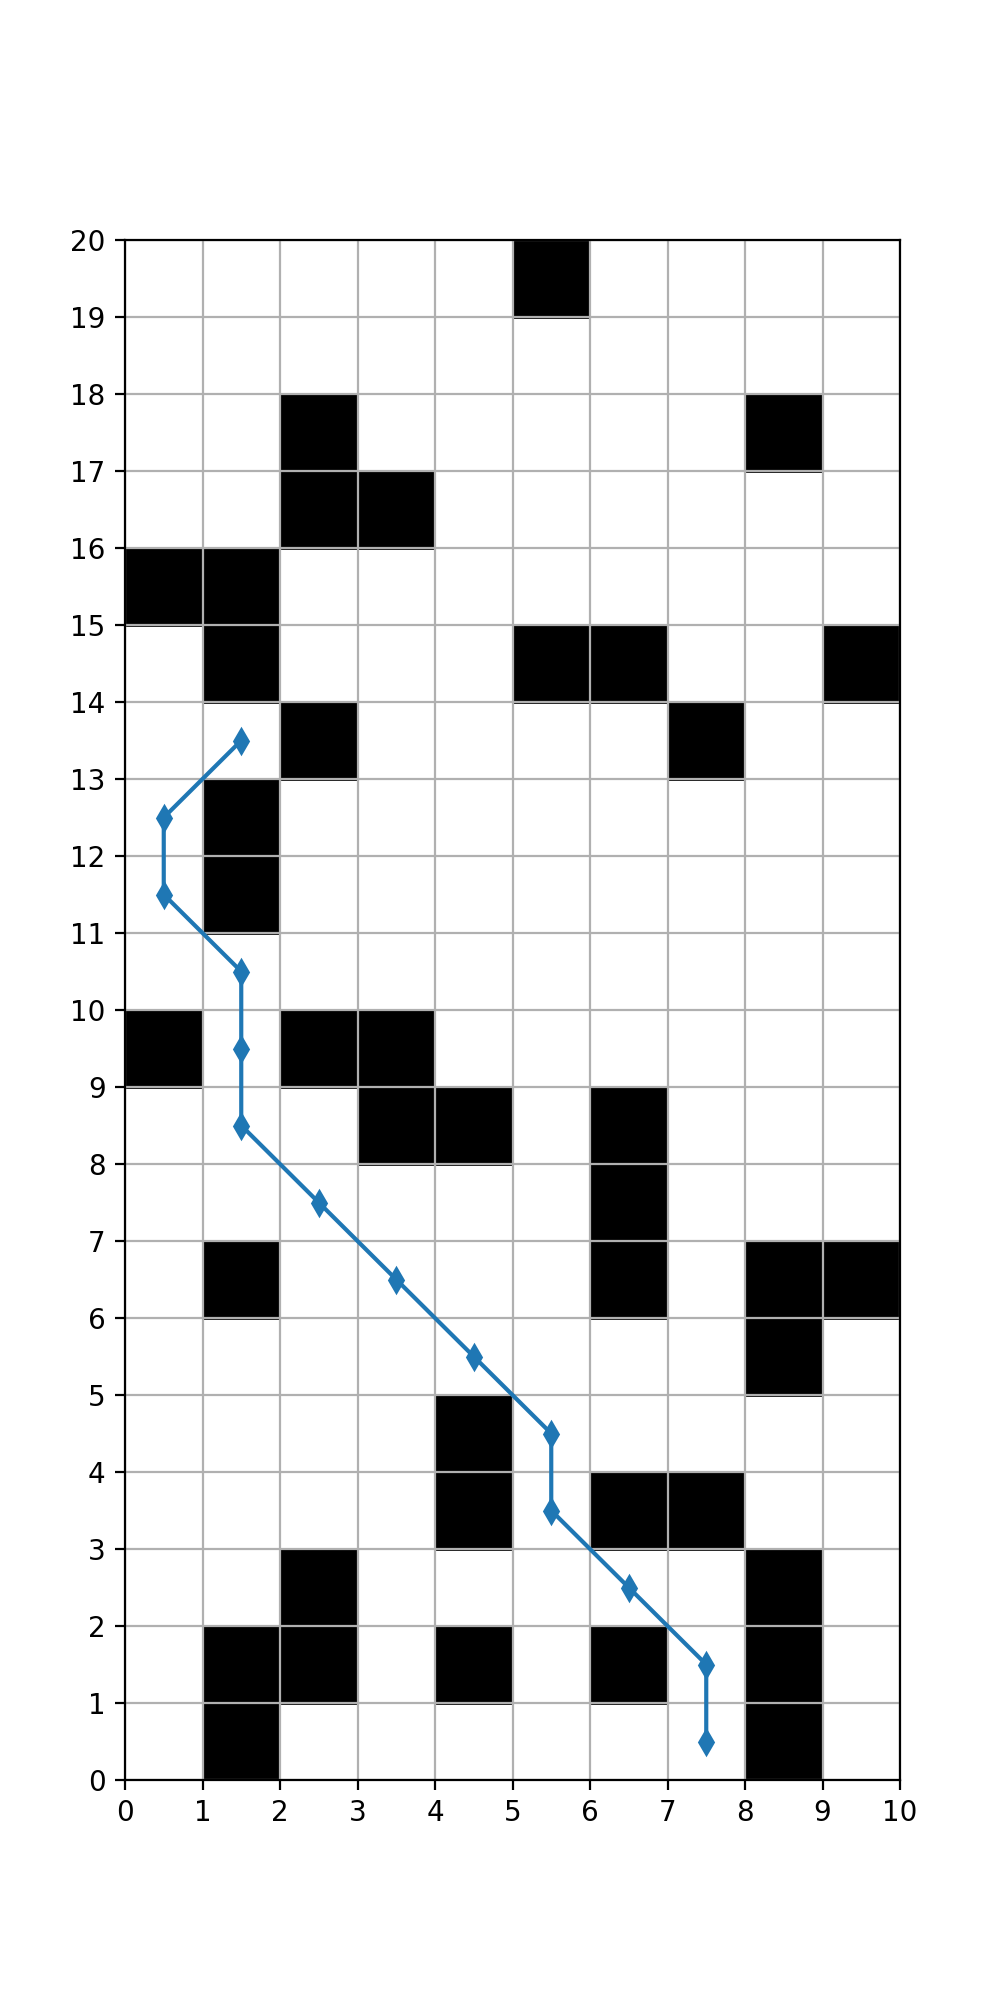

In [166]:
a_star_print((7,0),(1,13))

<IPython.core.display.Javascript object>


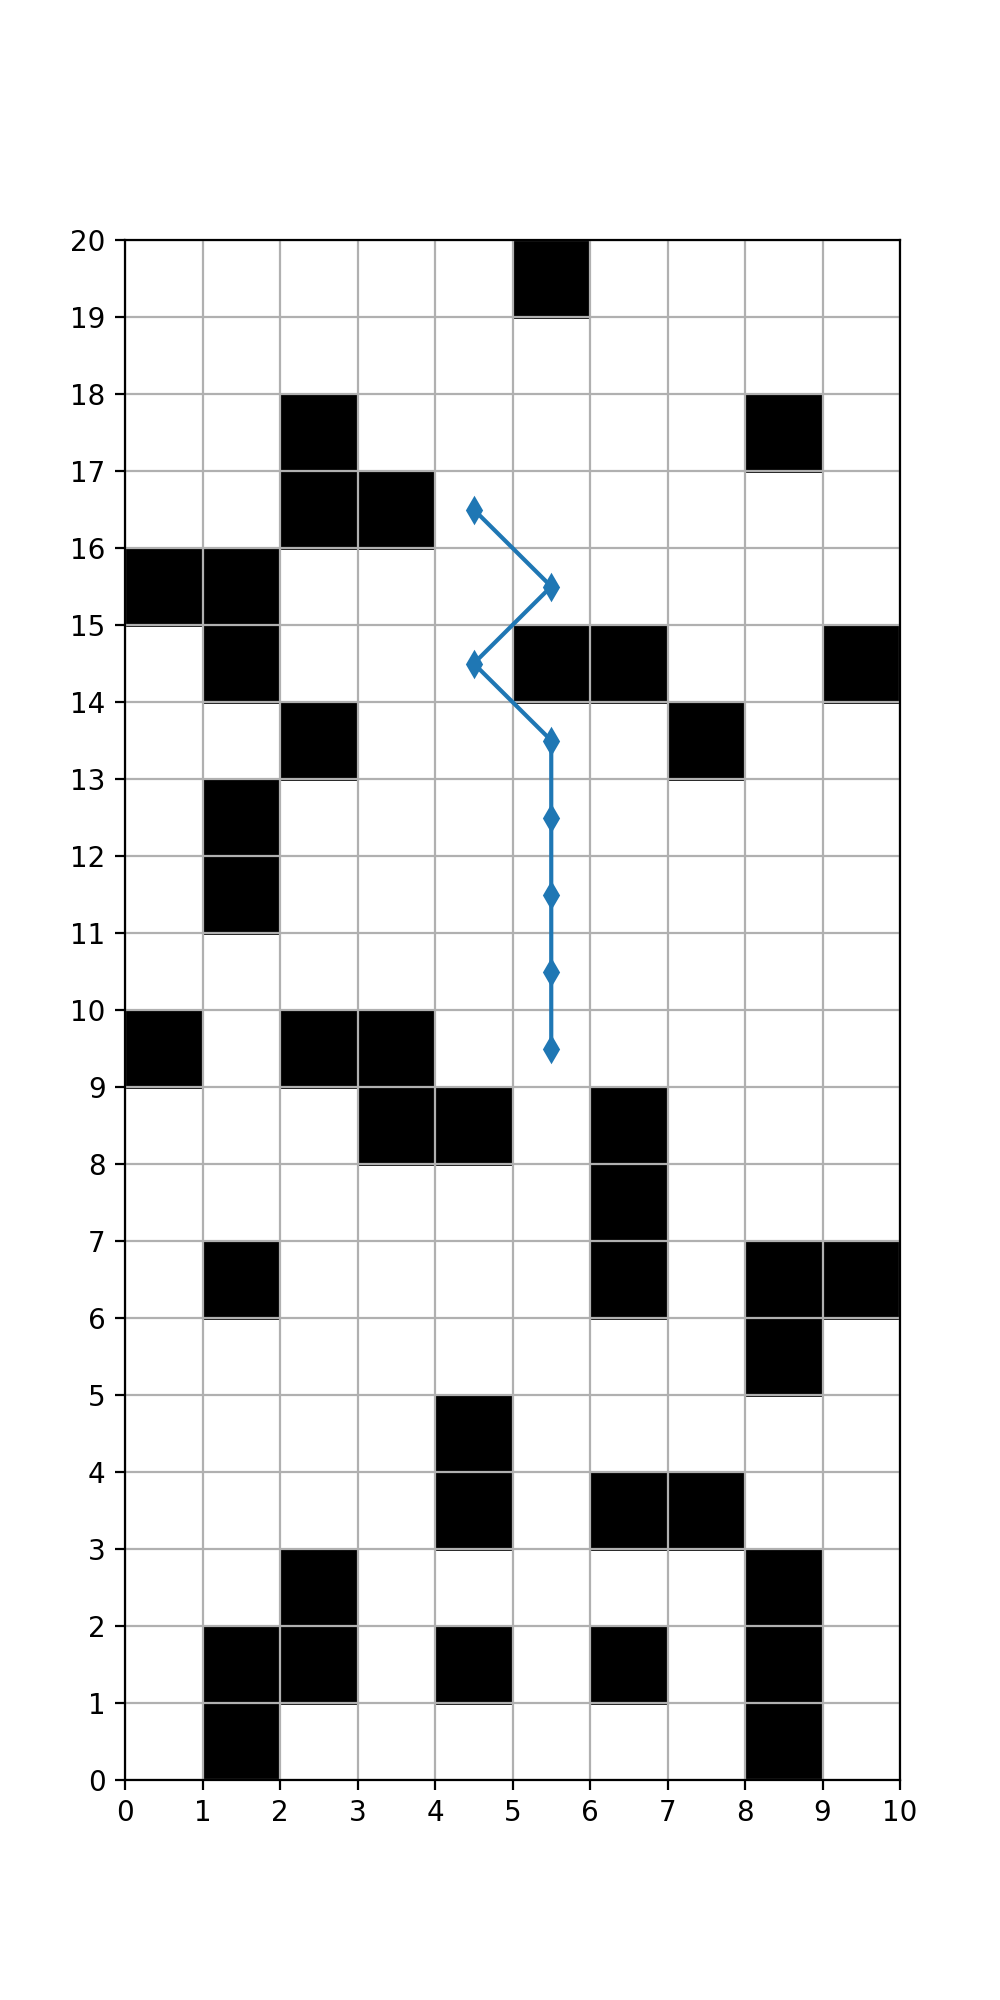

<IPython.core.display.Javascript object>


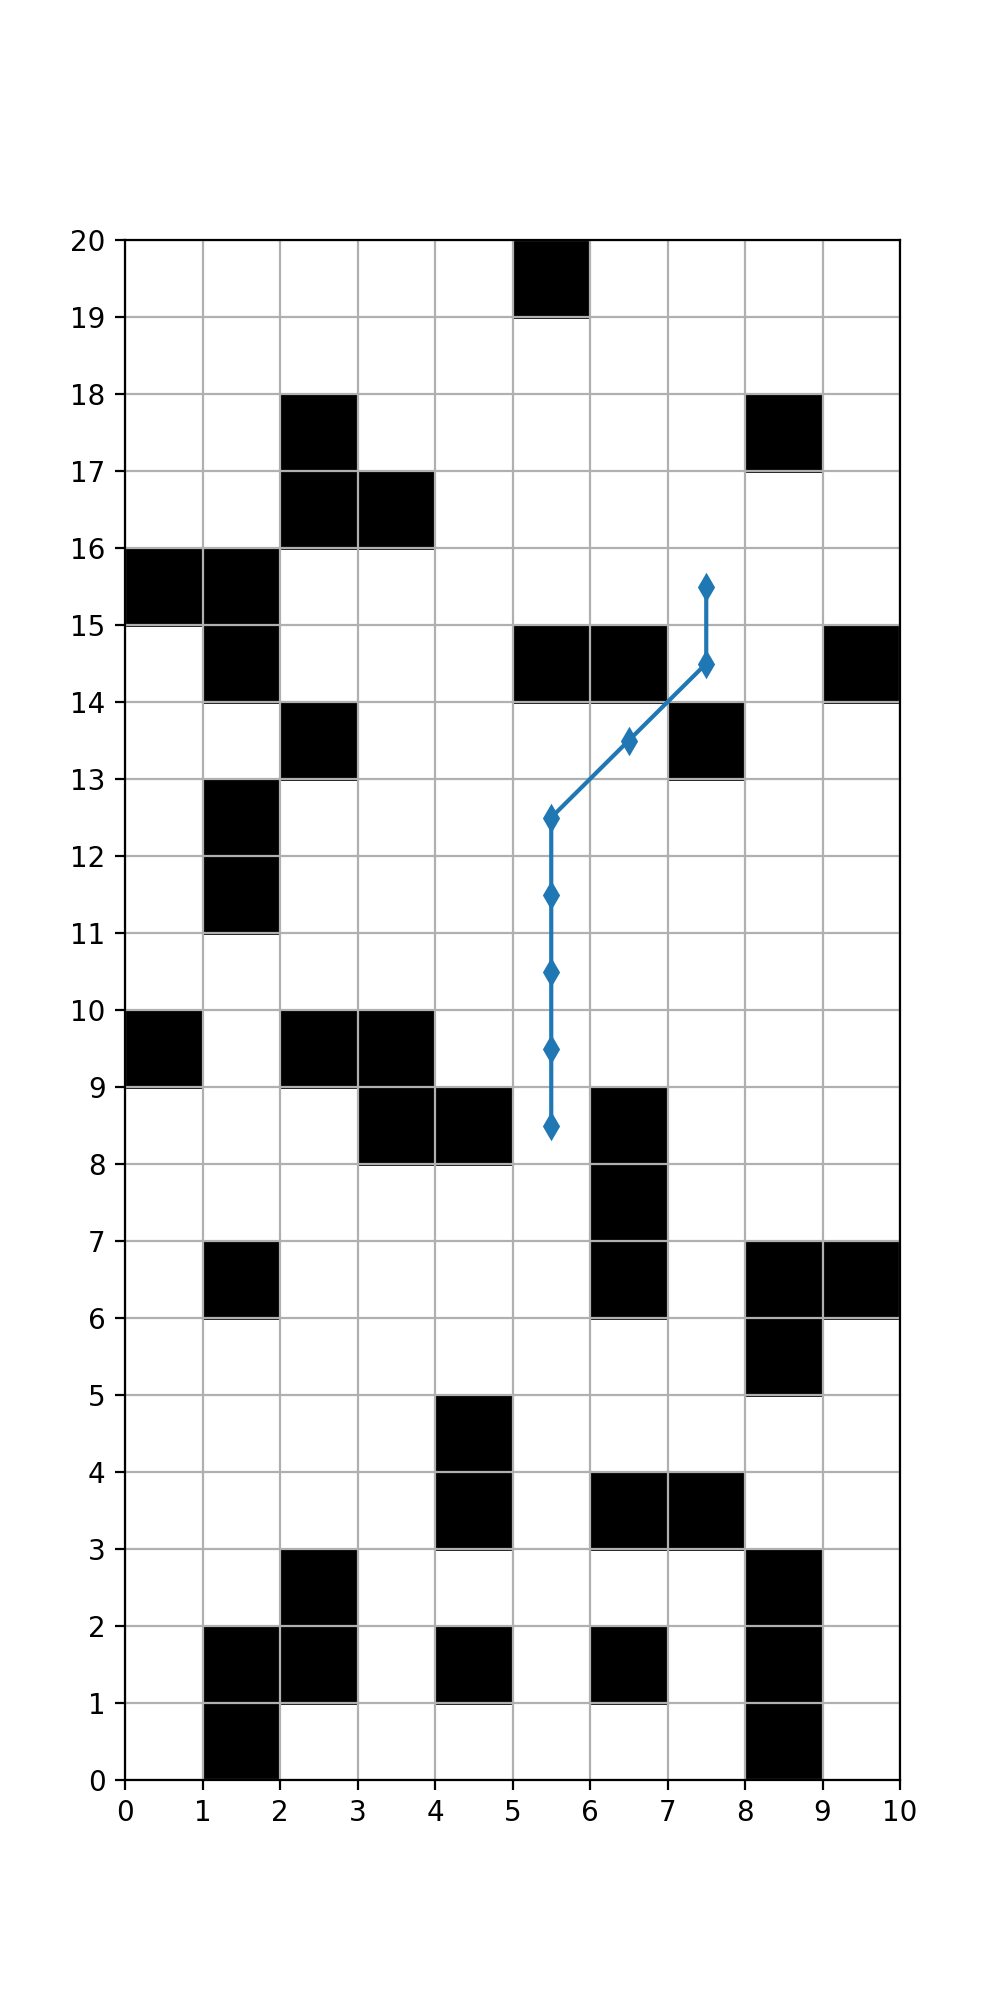

<IPython.core.display.Javascript object>


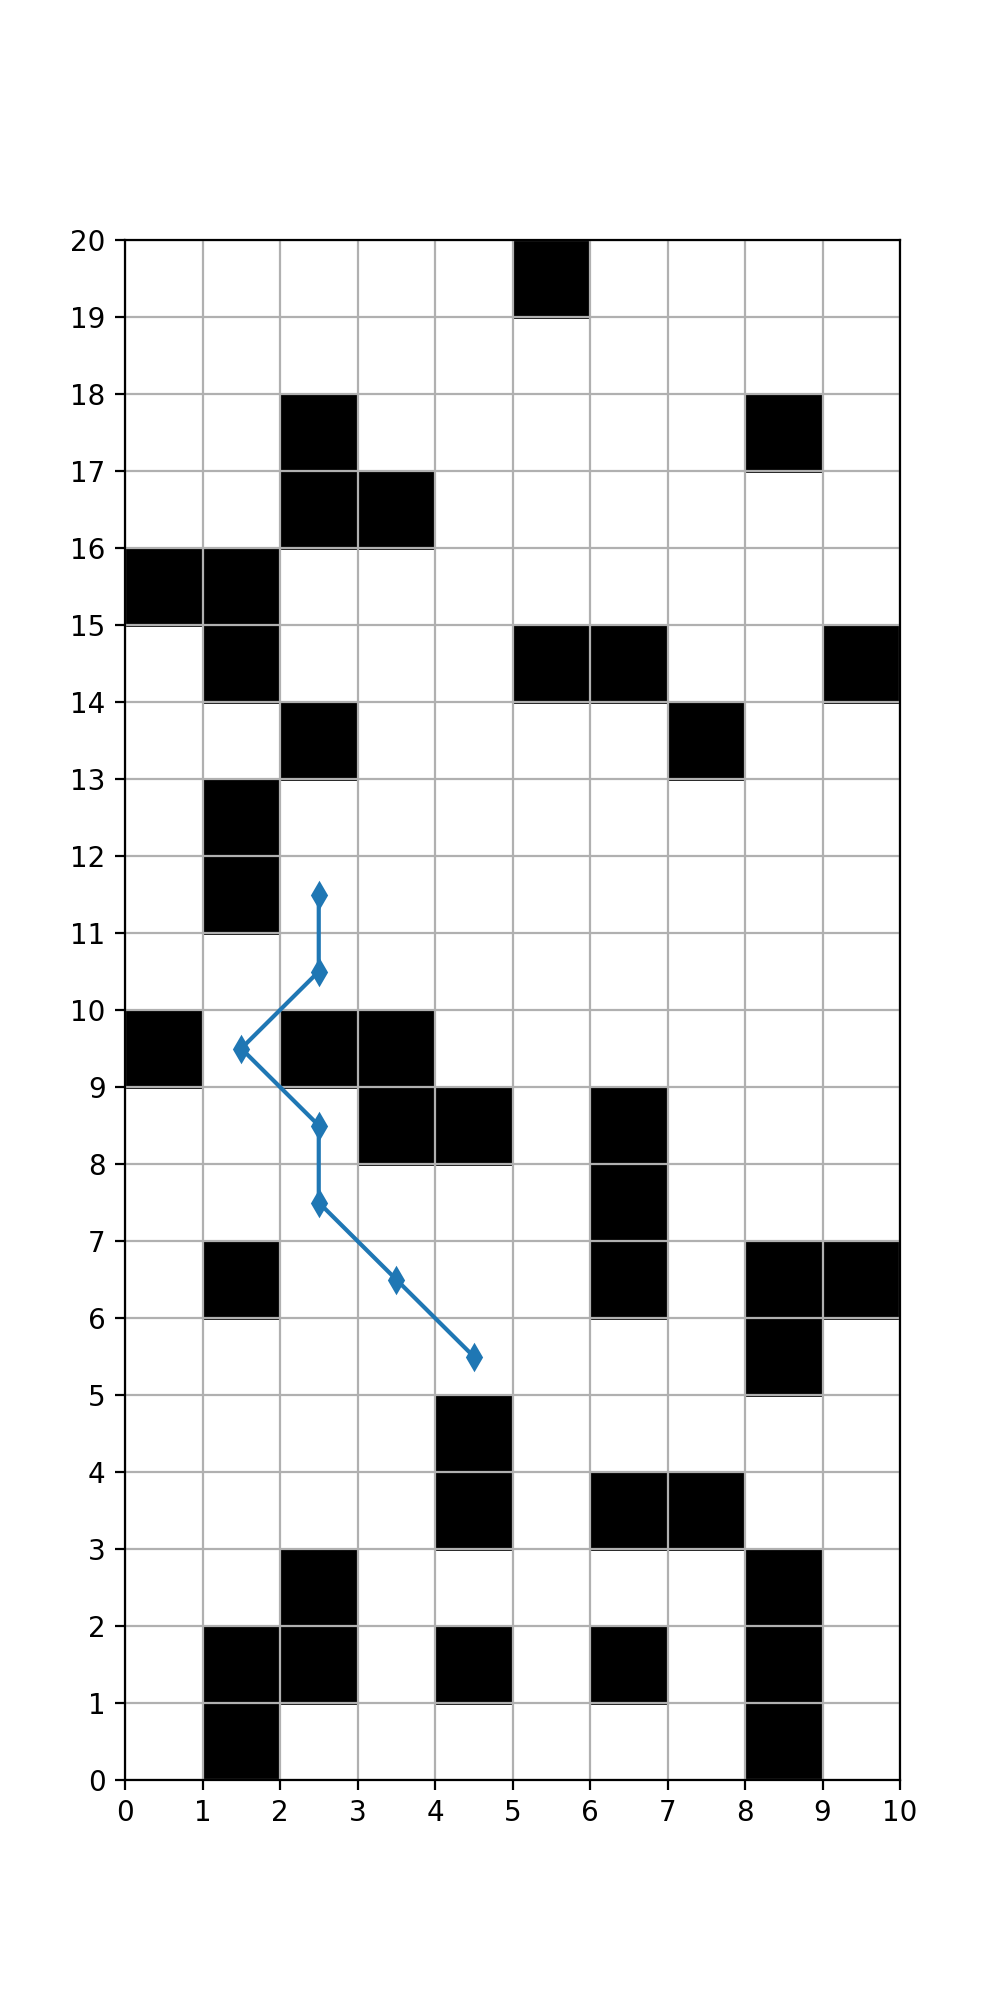

<IPython.core.display.Javascript object>


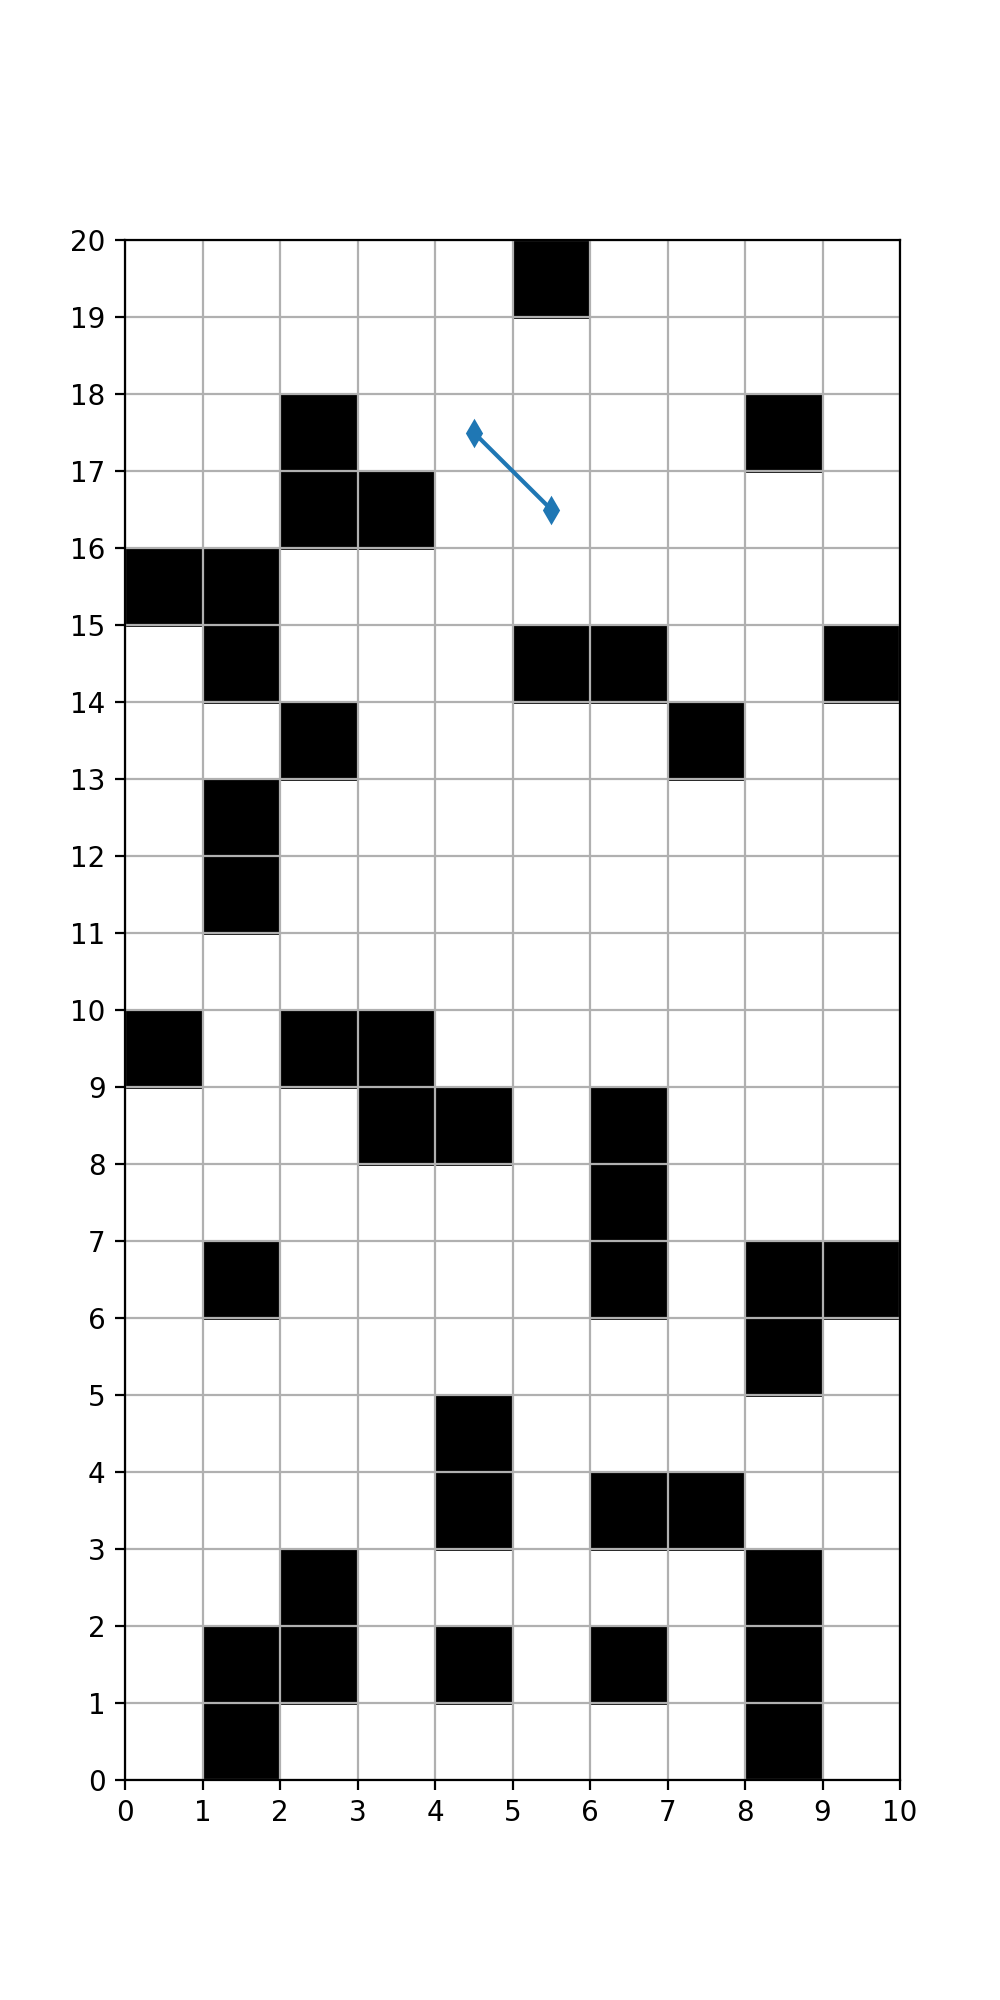

<IPython.core.display.Javascript object>


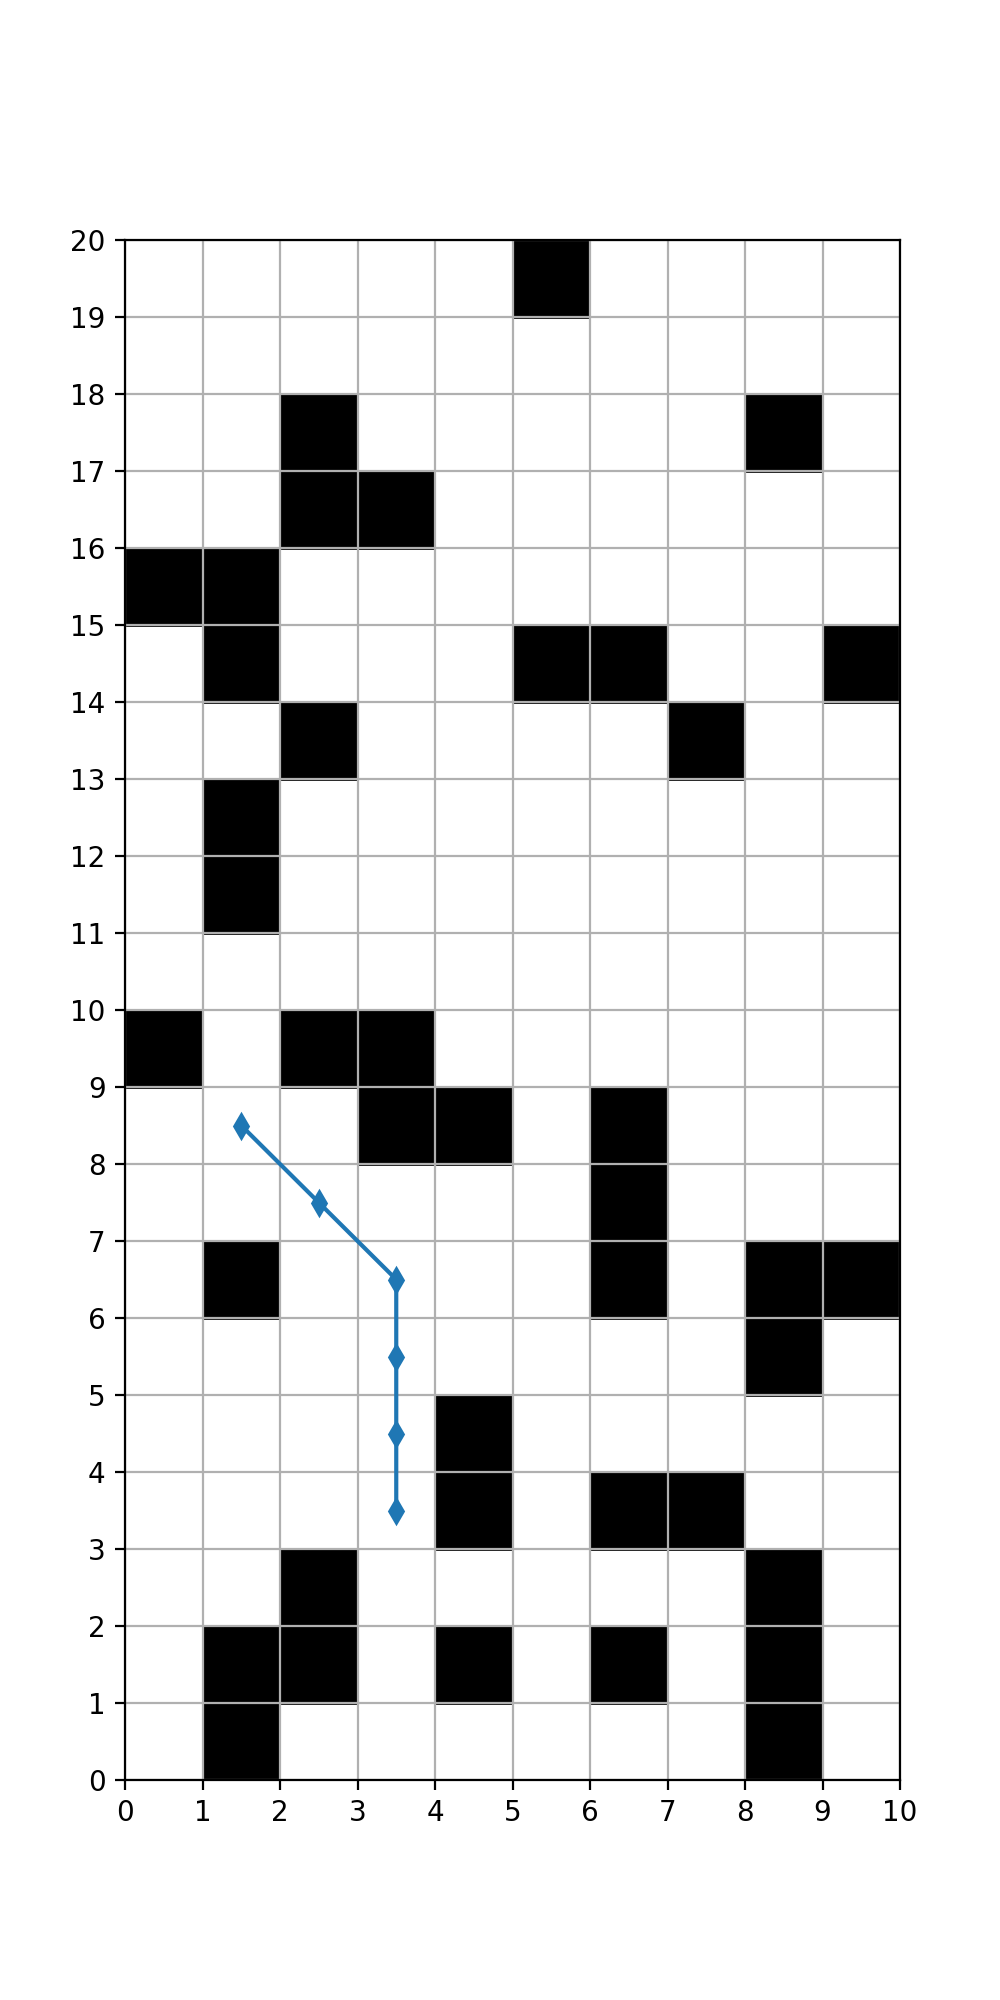

In [169]:
def choose_free_point():
    x_r = len(maze)
    y_r = len(maze[0])
    
    i = np_rnd.randint(0, x_r)
    j = np_rnd.randint(0, y_r)
    
    while maze[i][j] == 0:
        i = np_rnd.randint(0, x_r)
        j = np_rnd.randint(0, y_r)
        
    return (i,j)

for _ in range(5):
    p0 = choose_free_point()
    p1 = choose_free_point()
    
    #if
    while p0 == p1:
        p1 = choose_free_point()
        
    a_star_print(p0, p1)